In [1]:
!pip install -U numpy==1.26.4 scipy==1.13.1 scikit-learn==1.5.2 joblib==1.4.2 librosa==0.10.2.post1 lightgbm==4.5.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 24.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: joblib
    Found existing installation: joblib 1.5.1
    Uninstalling joblib-1.5.1:
      Successfully uninstalled joblib-1.5.1
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled sci

In [2]:
import sys, numpy, scipy, sklearn, joblib, librosa, lightgbm

print("Python   :", sys.version.split()[0])
print("NumPy    :", numpy.__version__)
print("SciPy    :", scipy.__version__)
print("sklearn  :", sklearn.__version__)
print("joblib   :", joblib.__version__)
print("librosa  :", librosa.__version__)
print("LightGBM :", lightgbm.__version__)


Python   : 3.12.11
NumPy    : 1.26.4
SciPy    : 1.13.1
sklearn  : 1.5.2
joblib   : 1.4.2
librosa  : 0.10.2.post1
LightGBM : 4.6.0


In [6]:
import os, json, joblib
from pathlib import Path
import numpy as np
import librosa
from scipy.signal import butter, sosfiltfilt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, f1_score)
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GroupShuffleSplit

# --------------------- CONFIG ---------------------
DATA_DIR = "/content/drive/MyDrive/COOP_Project/data_all_tester"
PATTERNS = {
    0: "mast_*.wav",
    1: "elevator_*.wav",
    2: "gripper_*.wav",
    3: "shuttle_*.wav",
    4: "environment_*.wav",
    5: "mast_bearing_broken_*.wav"
}
SR = 22050
SEG_DUR = 2.0
OVERLAP = 1.0
N_MFCC = 13
BP_LO, BP_HI = 400.0, 4000.0
PREEMPH = 0.97
N_FFT = 2048
HOP = 512
RAND_SEED = 1337
VAL_RATIO = 0.2
USE_EMA_CMVN = False      # <<< BEST for deploy with EMA
EMA_ALPHA = 0.02      # 0.01–0.05 reasonable
OUT_DIR = Path("/content/models"); OUT_DIR.mkdir(parents=True, exist_ok=True)

rng = np.random.default_rng(RAND_SEED)

# --------------------- IO & Segmentation ---------------------
from pathlib import Path

def load_signals(base_path: str, pattern: str, sr: int = SR):
    items = []
    for p in sorted(Path(base_path).glob(pattern)):
        try:
            y, _ = librosa.load(str(p), sr=sr)
            items.append((y.astype(np.float32), p.stem))
        except Exception as e:
            print(f"[WARN] load failed {p}: {e}")
    return items


def segment_signal(y: np.ndarray, sr: int = SR, seg_dur: float = SEG_DUR, overlap: float = OVERLAP):
    seg_len = int(round(seg_dur * sr))
    hop = max(1, seg_len - int(round(overlap * sr)))
    N = len(y)
    out = [y[i:i+seg_len] for i in range(0, max(0, N - seg_len + 1), hop)]
    if N >= seg_len and (N - seg_len) % hop != 0:
        out.append(y[-seg_len:])
    return out

# --------------------- DSP (Pre‑emph + Band‑pass) ---------------------
from scipy.signal import butter, sosfiltfilt

def pre_emphasis(x: np.ndarray, coeff: float = PREEMPH) -> np.ndarray:
    x = np.asarray(x, dtype=np.float32)
    y = np.empty_like(x)
    y[0] = x[0]
    y[1:] = x[1:] - coeff * x[:-1]
    return y


def _bp_sos(sr: int, lo: float, hi: float, order: int = 4):
    nyq = 0.5 * sr
    lo_n = max(1.0, lo) / nyq
    hi_n = min(hi, nyq - 1.0) / nyq
    if not (0.0 < lo_n < hi_n < 1.0):
        raise ValueError(f"Invalid band ({lo}, {hi}) for sr={sr}")
    return butter(order, [lo_n, hi_n], btype="band", output="sos")


def bandpass(x: np.ndarray, sr: int, lo: float = BP_LO, hi: float = BP_HI, order: int = 4) -> np.ndarray:
    return sosfiltfilt(_bp_sos(sr, lo, hi, order), np.asarray(x, dtype=np.float32))

# --------------------- Frame‑wise EMA‑CMVN ---------------------

def ema_cmvn_frames(M: np.ndarray, alpha: float = EMA_ALPHA, eps: float = 1e-6) -> np.ndarray:
    """M: (C, T) MFCC frames. Online EMA mean/var per channel across time.
    Returns normalized (C, T)."""
    C, T = M.shape
    out = np.empty_like(M, dtype=np.float32)
    mu = np.zeros(C, dtype=np.float32)
    var = np.ones(C, dtype=np.float32)
    warmup = True
    for t in range(T):
        x = M[:, t].astype(np.float32)
        if warmup:
            mu = x
            var = np.ones(C, dtype=np.float32)
            warmup = False
        else:
            mu = (1 - alpha) * mu + alpha * x
            var = (1 - alpha) * var + alpha * (x - mu) ** 2
        out[:, t] = (x - mu) / np.sqrt(var + eps)
    return out

# --------------------- Feature extraction (Train = Deploy) ---------------------

def features_from_segment(seg: np.ndarray, sr: int = SR, n_mfcc: int = N_MFCC) -> np.ndarray:
    x = pre_emphasis(seg)
    x = bandpass(x, sr)
    mfcc = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=n_mfcc, n_fft=N_FFT, hop_length=HOP)  # (C,T)

    if USE_EMA_CMVN:
        mfcc_n = ema_cmvn_frames(mfcc, alpha=EMA_ALPHA)
        # Warm-up: ตัด ~10% เฟรม แต่ไม่น้อยกว่า 3 และไม่เกิน 20
        T = mfcc_n.shape[1]
        W = min(20, max(3, int(0.10 * T)))
        mf = mfcc_n[:, W:] if T > W else mfcc_n

        # ชุดเบา/เสถียร (แนะนำ): mean + Q25 + Q75
        feat = np.concatenate([
            mf.mean(axis=1),
            np.percentile(mf, 25, axis=1),
            np.percentile(mf, 75, axis=1),
        ]).astype(np.float32)  # 3*C
    else:
        dmfcc = librosa.feature.delta(mfcc, width=5, order=1, mode="nearest")
        rms = float(np.sqrt(np.mean(np.square(x)) + 1e-12))
        logE = float(np.log(rms + 1e-12))
        feat = np.concatenate([
            mfcc.mean(axis=1),
            mfcc.std(axis=1),
            dmfcc.mean(axis=1),
            [logE],
        ]).astype(np.float32)  # 40D
    return feat


# --------------------- Build dataset ---------------------

def build_dataset(base_dir: str, patterns: dict):
    X_list, y_list, g_list = [], [], []
    for label, pattern in patterns.items():
        for sig, stem in load_signals(base_dir, pattern):
            for seg in segment_signal(sig, sr=SR, seg_dur=SEG_DUR, overlap=OVERLAP):
                X_list.append(features_from_segment(seg, SR, N_MFCC))
                y_list.append(int(label))
                g_list.append(stem)  # กลุ่มตามไฟล์
    X = np.vstack(X_list).astype(np.float32)
    y = np.asarray(y_list, dtype=int)
    groups = np.asarray(g_list)
    return X, y, groups


X, y, groups = build_dataset(DATA_DIR, PATTERNS)
print("Dataset:",X[1].shape , X.shape, y.shape, "#groups=", len(np.unique(groups)))



Dataset: (40,) (1009, 40) (1009,) #groups= 886


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[Saved] /content/models/tsne_2d.csv
[Saved] /content/models/tsne_sus_near_env.csv
[Saved] /content/models/tsne_lof_outliers.csv
[Saved] /content/models/tsne_2d.png


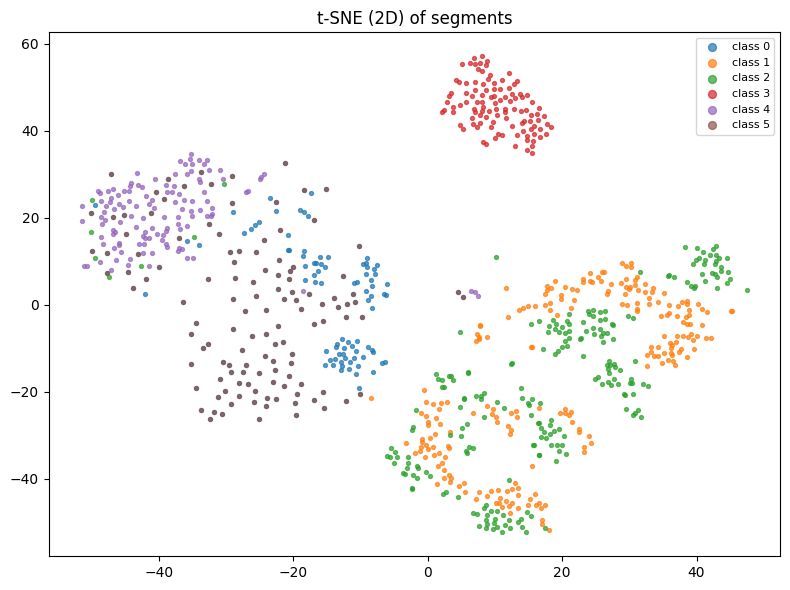

In [7]:
# =============== t-SNE Inspection ===============
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.neighbors import LocalOutlierFactor

ENV_LABEL = 4  # environment_*.wav

# 1) เตรียมฟีเจอร์สำหรับ t-SNE
if USE_EMA_CMVN:
    Xv = X
    scaler_vis = None
else:
    scaler_vis = StandardScaler().fit(X)
    Xv = scaler_vis.transform(X)

# 2) t-SNE 2D
tsne = TSNE(
    n_components=2, perplexity=30, learning_rate="auto",
    init="pca", n_iter=1000, random_state=RAND_SEED
)
Z = tsne.fit_transform(Xv)  # (N,2)

# 3) หา centroid per class (ใน latent 2D)
centroids = {}
for c in np.unique(y):
    centroids[c] = Z[y==c].mean(axis=0)

# 4) ชี้ตัวอย่าง non-env ที่ "ใกล้ environment" ผิดปกติ
#    - คิดระยะจากจุด ไปยัง centroid_env
#    - non-env ที่ระยะ <= p10 ของระยะ non-env ทั้งหมด → น่าสงสัย
env_c = centroids.get(ENV_LABEL, None)
sus_env = pd.DataFrame()
if env_c is not None:
    non_env_idx = np.where(y != ENV_LABEL)[0]
    d2_env = np.linalg.norm(Z[non_env_idx] - env_c, axis=1)
    p10 = np.quantile(d2_env, 0.10)  # “เข้าใกล้” กว่ากลุ่มส่วนใหญ่
    mask_close = d2_env <= p10
    sus_env = pd.DataFrame({
        "idx": non_env_idx[mask_close],
        "group": groups[non_env_idx[mask_close]],
        "true_label": y[non_env_idx[mask_close]],
        "dist_to_env_centroid": d2_env[mask_close]
    }).sort_values("dist_to_env_centroid")

# 5) LOF ต่อคลาสเพื่อหาโครงสร้างเอาต์ไลเออร์ใน 2D
records = []
for c in np.unique(y):
    idx = np.where(y == c)[0]
    if len(idx) < 10:
        continue
    Zc = Z[idx]
    lof = LocalOutlierFactor(n_neighbors=min(20, len(idx)-1), contamination=0.05)
    ylof = lof.fit_predict(Zc)  # -1 = outlier
    scores = -lof.negative_outlier_factor_
    out_mask = (ylof == -1)
    if np.any(out_mask):
        for i, j in enumerate(idx[out_mask]):
            records.append({
                "idx": int(j),
                "group": groups[j],
                "true_label": int(c),
                "lof_score": float(scores[out_mask][i])
            })
sus_lof = pd.DataFrame(records).sort_values("lof_score", ascending=False)

# 6) รวมเป็นรายงาน และเซฟ
OUT_DIR.mkdir(parents=True, exist_ok=True)
pd.DataFrame({
    "x": Z[:,0], "y": Z[:,1], "label": y, "group": groups
}).to_csv(OUT_DIR / "tsne_2d.csv", index=False)

sus_env.to_csv(OUT_DIR / "tsne_sus_near_env.csv", index=False)
sus_lof.to_csv(OUT_DIR / "tsne_lof_outliers.csv", index=False)

print(f"[Saved] {OUT_DIR/'tsne_2d.csv'}")
print(f"[Saved] {OUT_DIR/'tsne_sus_near_env.csv'}")
print(f"[Saved] {OUT_DIR/'tsne_lof_outliers.csv'}")

# 7) พล็อต scatter สีตามคลาส (สวย ๆ พอเป็นไกด์)
plt.figure(figsize=(8,6))
for c in np.unique(y):
    m = (y == c)
    plt.scatter(Z[m,0], Z[m,1], s=8, label=f"class {c}", alpha=0.7)
plt.title("t-SNE (2D) of segments")
plt.legend(markerscale=2, fontsize=8)
plt.tight_layout()
plt.savefig(OUT_DIR / "tsne_2d.png", dpi=160)
print(f"[Saved] {OUT_DIR/'tsne_2d.png'}")


##model

In [ ]:
# --------------------- Group‑aware split ---------------------
RAND = RAND_SEED
from sklearn.model_selection import GroupShuffleSplit
splitter = GroupShuffleSplit(n_splits=1, test_size=VAL_RATIO, random_state=RAND_SEED)
train_idx, val_idx = next(splitter.split(X, y, groups))
X_tr, y_tr, g_tr = X[train_idx], y[train_idx], groups[train_idx]
X_va, y_va, g_va = X[val_idx],   y[val_idx],   groups[val_idx]
print("Train:", X_tr.shape, " Val:", X_va.shape)

# --------------------- Normalization block ---------------------
scaler = None
if USE_EMA_CMVN:
    # Already normalized at frame level → DO NOT apply global scaler
    X_tr_n, X_va_n = X_tr, X_va
else:
    scaler = StandardScaler().fit(X_tr)
    X_tr_n = scaler.transform(X_tr)
    X_va_n = scaler.transform(X_va)

# --------------------- Classifier ---------------------
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.svm import OneClassSVM
import joblib, json
import numpy as np

# --------------------- Classifiers ---------------------
models = {
    "log_reg": LogisticRegression(max_iter=2000, solver='lbfgs', n_jobs=-1,class_weight="balanced", random_state=RAND_SEED),
    "rf": RandomForestClassifier(n_estimators=200, random_state=RAND_SEED, n_jobs=-1),
    "gb": GradientBoostingClassifier(random_state=RAND_SEED),
    "dt": DecisionTreeClassifier(random_state=RAND_SEED),
        "lgbm": LGBMClassifier(
        objective="multiclass",
        n_estimators=400,
        learning_rate=0.1,
        num_leaves=31,
        max_depth=-1,
        min_child_samples=5,
        min_split_gain=0.0,
        max_bin=255,
        subsample=0.9,
        colsample_bytree=0.9,
        class_weight="balanced",
        n_jobs=-1,
        random_state=RAND,
        verbose=-1
    ),
}

# --------------------- Train & Eval ---------------------
for name, clf in models.items():
    clf.fit(X_tr_n, y_tr)

    y_pred = clf.predict(X_va_n)
    acc = accuracy_score(y_va, y_pred)
    f1m = f1_score(y_va, y_pred, average='macro')
    print(f"[{name}] Acc: {acc:.4f}  F1m: {f1m:.4f}")
    print(classification_report(y_va, y_pred, digits=4))
    print(confusion_matrix(y_va, y_pred))

    # save each model
    joblib.dump(clf, OUT_DIR / f"{name}.joblib")

# --------------------- OCSVM ---------------------
# (A) Global
ocsvm_global = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')
ocsvm_global.fit(X_tr_n)
joblib.dump(ocsvm_global, OUT_DIR/"ocsvm_global.joblib")

# (B) Per-class
per_cls = {}
for c in np.unique(y_tr):
    Xc = X_tr_n[y_tr == c]
    if len(Xc) >= 20:
        oc = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale').fit(Xc)
        per_cls[int(c)] = oc
if per_cls:
    joblib.dump(per_cls, OUT_DIR/"ocsvm_per_component.joblib")

# --------------------- Save Scaler & Config ---------------------
if scaler is not None:
    joblib.dump(scaler, OUT_DIR/"scaler.joblib")

with open(OUT_DIR/"norm_config.json", "w") as f:
    json.dump({
        "use_ema_cmvn": int(USE_EMA_CMVN),
        "ema_alpha": float(EMA_ALPHA),
        "sr": SR, "preemph": PREEMPH, "bp": [BP_LO, BP_HI],
        "n_fft": N_FFT, "hop": HOP, "n_mfcc": N_MFCC
    }, f)

print("All models saved to:", OUT_DIR)


Train: (811, 40)  Val: (198, 40)
[log_reg] Acc: 0.8788  F1m: 0.8417
              precision    recall  f1-score   support

           0     0.9375    0.4286    0.5882        35
           1     1.0000    0.9808    0.9903        52
           2     1.0000    1.0000    1.0000        49
           3     1.0000    1.0000    1.0000        26
           4     0.7273    1.0000    0.8421        16
           5     0.5000    0.8500    0.6296        20

    accuracy                         0.8788       198
   macro avg     0.8608    0.8766    0.8417       198
weighted avg     0.9164    0.8788    0.8745       198

[[15  0  0  0  3 17]
 [ 1 51  0  0  0  0]
 [ 0  0 49  0  0  0]
 [ 0  0  0 26  0  0]
 [ 0  0  0  0 16  0]
 [ 0  0  0  0  3 17]]
[rf] Acc: 0.8788  F1m: 0.8314
              precision    recall  f1-score   support

           0     0.7586    0.6286    0.6875        35
           1     1.0000    1.0000    1.0000        52
           2     0.9800    1.0000    0.9899        49
           3   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/u

[lgbm] Acc: 0.8535  F1m: 0.8153
              precision    recall  f1-score   support

           0     0.8500    0.4857    0.6182        35
           1     1.0000    0.9615    0.9804        52
           2     1.0000    0.9796    0.9897        49
           3     1.0000    0.9615    0.9804        26
           4     0.7000    0.8750    0.7778        16
           5     0.4286    0.7500    0.5455        20

    accuracy                         0.8535       198
   macro avg     0.8298    0.8356    0.8153       198
weighted avg     0.8915    0.8535    0.8584       198

[[17  0  0  0  3 15]
 [ 0 50  0  0  0  2]
 [ 0  0 48  0  0  1]
 [ 0  0  0 25  0  1]
 [ 1  0  0  0 14  1]
 [ 2  0  0  0  3 15]]
All models saved to: /content/models


In [ ]:
# ==== Sanity checks ====
import numpy as np, joblib, json, warnings
from collections import Counter
from pathlib import Path

print("X:", X.shape, " y:", y.shape, " unique groups:", len(np.unique(groups)))
print("Class counts:", Counter(y))
# segments per file (few examples)
_, counts = np.unique(groups, return_counts=True)
print("Segments/file: mean=", counts.mean(), " median=", np.median(counts), " min=", counts.min(), " max=", counts.max())

# ==== Train/Val split (prefer StratifiedGroupKFold if available) ====
from sklearn.model_selection import GroupShuffleSplit

def stratified_group_split(X, y, groups, test_size=VAL_RATIO, random_state=RAND_SEED):
    try:
        from sklearn.model_selection import StratifiedGroupKFold
        sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=random_state)
        # Take first fold as val
        for tr_idx, va_idx in sgkf.split(X, y, groups):
            return tr_idx, va_idx
    except Exception as e:
        warnings.warn(f"StratifiedGroupKFold not available ({e}); using GroupShuffleSplit (not stratified).")
        gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
        tr_idx, va_idx = next(gss.split(X, y, groups))
        return tr_idx, va_idx

tr_idx, va_idx = stratified_group_split(X, y, groups, test_size=VAL_RATIO, random_state=RAND_SEED)
X_tr, y_tr, g_tr = X[tr_idx], y[tr_idx], groups[tr_idx]
X_va, y_va, g_va = X[va_idx], y[va_idx], groups[va_idx]

print("Train:", X_tr.shape, Counter(y_tr))
print("Valid:", X_va.shape, Counter(y_va))

# ==== Multiclass component classifier ====
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# With EMA-CMVN features, no scaler needed. If you turn EMA off, consider StandardScaler().
clf = LogisticRegression(
    max_iter=3000,
    solver="saga",
    n_jobs=-1,
    class_weight="balanced",
    random_state=RAND_SEED,
    multi_class="auto"
)
clf.fit(X_tr, y_tr)

yhat = clf.predict(X_va)
acc  = accuracy_score(y_va, yhat)
f1m  = f1_score(y_va, yhat, average="macro")
print(f"[Multiclass] Acc={acc:.3f}  F1(macro)={f1m:.3f}")
print("Confusion matrix:\n", confusion_matrix(y_va, yhat))
print(classification_report(y_va, yhat, digits=3))

# ==== Binary fault head (label 5 = fault, others = normal) ====
is_fault_tr = (y_tr == 5).astype(int)
is_fault_va = (y_va == 5).astype(int)

clf_fault = LogisticRegression(
    max_iter=3000,
    solver="saga",
    n_jobs=-1,
    class_weight="balanced",
    random_state=RAND_SEED
)
clf_fault.fit(X_tr, is_fault_tr)

yhat_f = clf_fault.predict(X_va)
acc_f  = accuracy_score(is_fault_va, yhat_f)
f1_f   = f1_score(is_fault_va, yhat_f, average="binary")
print(f"[Fault vs Normal] Acc={acc_f:.3f}  F1={f1_f:.3f}")
print("Confusion matrix (fault head):\n", confusion_matrix(is_fault_va, yhat_f))
print(classification_report(is_fault_va, yhat_f, digits=3))

# ==== Save artifacts ====
OUT_DIR.mkdir(parents=True, exist_ok=True)
joblib.dump(clf, OUT_DIR / "log_reg_multiclass.joblib")
joblib.dump(clf_fault, OUT_DIR / "log_reg_fault.joblib")
with open(OUT_DIR / "label_map.json", "w") as f:
    json.dump({0:"mast",1:"elevator",2:"gripper",3:"shuttle",4:"environment",5:"mast_bearing_broken"}, f, indent=2)
print("Saved models to:", OUT_DIR)


X: (1009, 40)  y: (1009,)  unique groups: 886
Class counts: Counter({np.int64(2): 232, np.int64(1): 219, np.int64(0): 206, np.int64(5): 123, np.int64(4): 122, np.int64(3): 107})
Segments/file: mean= 1.1388261851015802  median= 1.0  min= 1  max= 2
Train: (807, 40) Counter({np.int64(2): 186, np.int64(1): 176, np.int64(0): 165, np.int64(5): 98, np.int64(4): 97, np.int64(3): 85})
Valid: (202, 40) Counter({np.int64(2): 46, np.int64(1): 43, np.int64(0): 41, np.int64(4): 25, np.int64(5): 25, np.int64(3): 22})


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[Multiclass] Acc=0.842  F1(macro)=0.823
Confusion matrix:
 [[18  0  0  0  7 16]
 [ 0 43  0  0  0  0]
 [ 0  0 46  0  0  0]
 [ 0  0  0 22  0  0]
 [ 0  0  0  0 25  0]
 [ 3  0  0  0  6 16]]
              precision    recall  f1-score   support

           0      0.857     0.439     0.581        41
           1      1.000     1.000     1.000        43
           2      1.000     1.000     1.000        46
           3      1.000     1.000     1.000        22
           4      0.658     1.000     0.794        25
           5      0.500     0.640     0.561        25

    accuracy                          0.842       202
   macro avg      0.836     0.847     0.823       202
weighted avg      0.867     0.842     0.835       202

[Fault vs Normal] Acc=0.856  F1=0.623
Confusion matrix (fault head):
 [[149  28]
 [  1  24]]
              precision    recall  f1-score   support

           0      0.993     0.842     0.911       177
           1      0.462     0.960     0.623        25

    accuracy  

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
# --------------------- Runtime benchmark: LogReg vs LGBM ---------------------
import time, json
from collections import OrderedDict
import numpy as np

try:
    import pandas as pd
except ImportError:
    pd = None  # ไม่มี pandas ก็ยังพิมพ์ผลใน stdout ได้

def bench_model(name, clf, X_tr, y_tr, X_va, y_va):
    # --- FIT ---
    t0_wc = time.perf_counter()
    t0_cpu = time.process_time()
    clf.fit(X_tr, y_tr)
    fit_wc  = time.perf_counter() - t0_wc
    fit_cpu = time.process_time() - t0_cpu

    # --- PREDICT ---
    t1_wc = time.perf_counter()
    t1_cpu = time.process_time()
    y_pred = clf.predict(X_va)
    pred_wc  = time.perf_counter() - t1_wc
    pred_cpu = time.process_time() - t1_cpu

    # --- METRICS ---
    from sklearn.metrics import accuracy_score, f1_score
    acc  = accuracy_score(y_va, y_pred)
    f1m  = f1_score(y_va, y_pred, average="macro")

    # --- THROUGHPUT (samples/sec) ---
    ntr = len(X_tr); nva = len(X_va)
    fit_thr  = ntr / fit_wc if fit_wc > 0 else float("inf")
    pred_thr = nva / pred_wc if pred_wc > 0 else float("inf")

    return OrderedDict([
        ("model", name),
        ("fit_wall_s", round(fit_wc, 6)),
        ("fit_cpu_s",  round(fit_cpu, 6)),
        ("pred_wall_s",round(pred_wc, 6)),
        ("pred_cpu_s", round(pred_cpu, 6)),
        ("fit_thr_sps",round(fit_thr, 2)),
        ("pred_thr_sps",round(pred_thr, 2)),
        ("acc", round(acc, 4)),
        ("f1_macro", round(f1m, 4)),
        ("n_train", int(ntr)),
        ("n_valid", int(nva)),
        ("n_feat", int(X_tr.shape[1])),
    ])

# เลือกเฉพาะสองรุ่นที่จะ benchmark
models_bench  = {
    "log_reg": LogisticRegression(max_iter=2000, solver='lbfgs', n_jobs=-1, random_state=RAND_SEED),
    "rf": RandomForestClassifier(n_estimators=200, random_state=RAND_SEED, n_jobs=-1),
    "gb": GradientBoostingClassifier(random_state=RAND_SEED),
        "ridge": RidgeClassifier(class_weight="balanced", random_state=RAND),
    "sgd_log": SGDClassifier(loss="log_loss", max_iter=2000, class_weight="balanced",
                             random_state=RAND),
    "lin_svc": LinearSVC(class_weight="balanced", random_state=RAND),  # no prob

    "et": ExtraTreesClassifier(n_estimators=400, max_depth=None, n_jobs=-1,
                               class_weight="balanced", random_state=RAND),
    "gnb": GaussianNB(),
    "knn": KNeighborsClassifier(n_neighbors=7, weights="distance"),

    "dt": DecisionTreeClassifier(random_state=RAND_SEED),
        "lgbm": LGBMClassifier(
        objective="multiclass",
        n_estimators=400,
        learning_rate=0.1,
        num_leaves=31,
        max_depth=-1,
        min_child_samples=5,
        min_split_gain=0.0,
        max_bin=255,
        subsample=0.9,
        colsample_bytree=0.9,
        class_weight="balanced",
        n_jobs=-1,
        random_state=RAND,
        verbose=-1
    ),
}


results = []
for name, clf in models_bench.items():
    res = bench_model(name, clf, X_tr_n, y_tr, X_va_n, y_va)
    results.append(res)
    print(f"[{name}] fit {res['fit_wall_s']:.3f}s | pred {res['pred_wall_s']:.3f}s | "
          f"thr_fit {res['fit_thr_sps']:.1f}/s | thr_pred {res['pred_thr_sps']:.1f}/s | "
          f"acc {res['acc']:.4f} | f1m {res['f1_macro']:.4f}")

# --- Save & pretty print ---
OUT_DIR.mkdir(parents=True, exist_ok=True)
with open(OUT_DIR / "runtime_benchmark.json", "w") as f:
    json.dump(results, f, indent=2)

if pd is not None:
    df = pd.DataFrame(results)
    df.to_csv(OUT_DIR / "runtime_benchmark.csv", index=False)
    # ถ้ารันในโน้ตบุ๊ก: display(df.sort_values("pred_wall_s"))


NameError: name 'RidgeClassifier' is not defined

In [ ]:
# --------------------- RAM benchmark helpers ---------------------
import os, time, threading, tempfile, io
from contextlib import contextmanager

# psutil สำหรับวัด RAM ทั้งโปรเซส (RSS); ถ้าไม่มีจะ fallback ไปใช้ tracemalloc
try:
    import psutil
    _HAS_PSUTIL = True
    _PROC = psutil.Process(os.getpid())
except Exception:
    _HAS_PSUTIL = False
    import tracemalloc

def _bytes_to_mb(b): return float(b) / (1024*1024)

class PeakRSSMonitor:
    """
    วัด RAM peak ระหว่างบล็อกโค้ด:
        with PeakRSSMonitor() as mon:
            ...do work...
        mon.peak_bytes -> ค่าจุดสูงสุด (bytes)
    ใช้ psutil ถ้ามี; ไม่มีก็ใช้ tracemalloc (จะวัดได้เฉพาะ Python heap)
    """
    def __init__(self, interval=0.02):
        self.interval = interval
        self.peak_bytes = 0
        self._stop = threading.Event()
        self._thr = None

    def _poll_psutil(self):
        while not self._stop.is_set():
            try:
                rss = _PROC.memory_info().rss
                if rss > self.peak_bytes:
                    self.peak_bytes = rss
            except Exception:
                pass
            time.sleep(self.interval)

    def __enter__(self):
        if _HAS_PSUTIL:
            self.peak_bytes = _PROC.memory_info().rss
            self._thr = threading.Thread(target=self._poll_psutil, daemon=True)
            self._thr.start()
        else:
            tracemalloc.start()
            self.peak_bytes = tracemalloc.get_traced_memory()[1]
        return self

    def __exit__(self, exc_type, exc, tb):
        if _HAS_PSUTIL:
            self._stop.set()
            if self._thr is not None:
                self._thr.join()
        else:
            current, peak = tracemalloc.get_traced_memory()
            self.peak_bytes = peak
            tracemalloc.stop()

def get_rss_mb():
    if _HAS_PSUTIL:
        return _bytes_to_mb(_PROC.memory_info().rss)
    return None  # ไม่มี psutil

def get_model_size_mb(model):
    # ประเมินขนาดไฟล์โมเดลหลังเทรน (joblib)
    import joblib
    with tempfile.NamedTemporaryFile(delete=True, suffix=".joblib") as tmp:
        joblib.dump(model, tmp.name)
        tmp.flush()
        return os.path.getsize(tmp.name) / (1024*1024)

# --------------------- Runtime + RAM benchmark: LogReg vs LGBM ---------------------
import time, json
from collections import OrderedDict

try:
    import pandas as pd
except ImportError:
    pd = None

def bench_model(name, clf, X_tr, y_tr, X_va, y_va):
    from sklearn.metrics import accuracy_score, f1_score

    rss_before_mb = get_rss_mb()

    # --- FIT ---
    with PeakRSSMonitor() as mon_fit:
        t0_wc = time.perf_counter(); t0_cpu = time.process_time()
        clf.fit(X_tr, y_tr)
        fit_wc  = time.perf_counter() - t0_wc
        fit_cpu = time.process_time() - t0_cpu
    fit_peak_mb = _bytes_to_mb(mon_fit.peak_bytes) if mon_fit.peak_bytes else None

    # ขนาดโมเดลหลังเทรน
    try:
        model_mb = round(get_model_size_mb(clf), 3)
    except Exception:
        model_mb = None

    # --- PREDICT ---
    with PeakRSSMonitor() as mon_pred:
        t1_wc = time.perf_counter(); t1_cpu = time.process_time()
        y_pred = clf.predict(X_va)
        pred_wc  = time.perf_counter() - t1_wc
        pred_cpu = time.process_time() - t1_cpu
    pred_peak_mb = _bytes_to_mb(mon_pred.peak_bytes) if mon_pred.peak_bytes else None

    # --- Metrics & throughput ---
    acc = accuracy_score(y_va, y_pred)
    f1m = f1_score(y_va, y_pred, average="macro")
    ntr, nva = len(X_tr), len(X_va)
    fit_thr  = ntr / fit_wc if fit_wc > 0 else float("inf")
    pred_thr = nva / pred_wc if pred_wc > 0 else float("inf")

    return OrderedDict([
        ("model", name),
        ("rss_start_mb", None if rss_before_mb is None else round(rss_before_mb, 3)),
        ("fit_peak_mb", None if fit_peak_mb is None else round(fit_peak_mb, 3)),
        ("pred_peak_mb", None if pred_peak_mb is None else round(pred_peak_mb, 3)),
        ("model_file_mb", model_mb),
        ("fit_wall_s", round(fit_wc, 6)),
        ("fit_cpu_s",  round(fit_cpu, 6)),
        ("pred_wall_s",round(pred_wc, 6)),
        ("pred_cpu_s", round(pred_cpu, 6)),
        ("fit_thr_sps",round(fit_thr, 2)),
        ("pred_thr_sps",round(pred_thr, 2)),
        ("acc", round(acc, 4)),
        ("f1_macro", round(f1m, 4)),
        ("n_train", int(ntr)),
        ("n_valid", int(nva)),
        ("n_feat", int(X_tr.shape[1])),
        ("psutil_used", bool(_HAS_PSUTIL)),
    ])

# เลือกสองรุ่น
models_bench = {
    "log_reg": LogisticRegression(max_iter=2000, solver="lbfgs", random_state=RAND_SEED),
    "lgbm": LGBMClassifier(
        objective="multiclass",
        n_estimators=400,
        learning_rate=0.1,
        num_leaves=31,
        max_depth=-1,
        min_child_samples=5,
        subsample=0.9,
        colsample_bytree=0.9,
        class_weight="balanced",
        n_jobs=-1,
        random_state=RAND,
        verbose=-1,
    ),
}

results = []
for name, clf in models_bench.items():
    res = bench_model(name, clf, X_tr_n, y_tr, X_va_n, y_va)
    results.append(res)
    print(
        f"[{name}] fit {res['fit_wall_s']:.3f}s | pred {res['pred_wall_s']:.3f}s | "
        f"peakRAM_fit {res['fit_peak_mb']} MB | peakRAM_pred {res['pred_peak_mb']} MB | "
        f"model {res['model_file_mb']} MB | acc {res['acc']:.4f} | f1m {res['f1_macro']:.4f}"
    )

# Save
OUT_DIR.mkdir(parents=True, exist_ok=True)
with open(OUT_DIR / "runtime_ram_benchmark.json", "w") as f:
    json.dump(results, f, indent=2)

if pd is not None:
    pd.DataFrame(results).to_csv(OUT_DIR / "runtime_ram_benchmark.csv", index=False)


In [ ]:
from pathlib import Path
import numpy as np, joblib, json
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
RAND = RAND_SEED
OUT = OUT_DIR
OUT.mkdir(parents=True, exist_ok=True)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

candidates = {
    "log_reg": LogisticRegression(max_iter=2000, solver="saga", n_jobs=-1,
                                  class_weight="balanced", random_state=RAND),
    "ridge": RidgeClassifier(class_weight="balanced", random_state=RAND),
    "sgd_log": SGDClassifier(loss="log_loss", max_iter=2000, class_weight="balanced",
                             random_state=RAND),
    "lin_svc": LinearSVC(class_weight="balanced", random_state=RAND),  # no prob

    "et": ExtraTreesClassifier(n_estimators=400, max_depth=None, n_jobs=-1,
                               class_weight="balanced", random_state=RAND),
    "gnb": GaussianNB(),
    "knn": KNeighborsClassifier(n_neighbors=7, weights="distance"),

    # LightGBM (มีอยู่แล้ว)
    "lgbm": LGBMClassifier(
        objective="multiclass",
        n_estimators=400,
        learning_rate=0.1,
        num_leaves=31,
        max_depth=-1,
        min_child_samples=5,
        min_split_gain=0.0,
        max_bin=255,
        subsample=0.9,
        colsample_bytree=0.9,
        class_weight="balanced",
        n_jobs=-1,
        random_state=RAND,
        verbose=-1
    ),

    # XGBoost
    "xgb": XGBClassifier(
        objective="multi:softprob",     # ให้ predict_proba สำหรับ multiclass
        eval_metric="mlogloss",         # metric มาตรฐาน
        n_estimators=400,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        n_jobs=-1,
        random_state=RAND,
        use_label_encoder=False
    ),

    # CatBoost
    "cat": CatBoostClassifier(
        iterations=500,
        learning_rate=0.1,
        depth=6,
        loss_function="MultiClass",
        random_seed=RAND,
        verbose=0
    ),
}
def maybe_calibrated(name, clf):
    # ให้ทุกตัวมี predict_proba (สำคัญต่อ gating/threshold ภายหลัง)
    need_cal = not hasattr(clf, "predict_proba")
    # LinearSVC/ Ridge/ ExtraTrees/ RandomForest บางตัวมี proba แล้วหรือไม่
    if name in ["lin_svc", "ridge"] or not hasattr(clf, "predict_proba"):
        return CalibratedClassifierCV(clf, cv=3, method="isotonic")
    return clf

results = []
best_models = {}

for name, base in candidates.items():
    clf = maybe_calibrated(name, base)
    clf.fit(X_tr_n, y_tr)
    y_pred = clf.predict(X_va_n)
    acc = accuracy_score(y_va, y_pred)
    f1m = f1_score(y_va, y_pred, average="macro")
    results.append((name, acc, f1m))
    print(f"[{name}] Acc={acc:.4f} F1m={f1m:.4f}")

# เลือก Top-3 ตาม macro-F1 แล้วเซฟ
results_sorted = sorted(results, key=lambda x: x[2], reverse=True)
for name, acc, f1m in results_sorted[:3]:
    clf = maybe_calibrated(name, candidates[name])
    clf.fit(np.vstack([X_tr_n, X_va_n]), np.hstack([y_tr, y_va]))  # retrain รวม train+val
    joblib.dump(clf, OUT / f"{name}.joblib")
    best_models[name] = {"acc_va": float(acc), "f1m_va": float(f1m)}

# --- Anomaly detectors ---
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

ocsvm_global = OneClassSVM(kernel="rbf", nu=0.05, gamma="scale").fit(X_tr_n)
joblib.dump(ocsvm_global, OUT / "ocsvm_global.joblib")

iso_global = IsolationForest(n_estimators=300, contamination=0.02,
                             random_state=RAND).fit(X_tr_n)
joblib.dump(iso_global, OUT / "iforest_global.joblib")

per_cls = {}
for c in np.unique(y_tr):
    Xc = X_tr_n[y_tr == c]
    if len(Xc) >= 50:
        per_cls[int(c)] = {
            "ocsvm": OneClassSVM(kernel="rbf", nu=0.05, gamma="scale").fit(Xc),
            "iforest": IsolationForest(n_estimators=200, contamination=0.02,
                                       random_state=RAND).fit(Xc),
        }
if per_cls:
    joblib.dump(per_cls, OUT / "anomaly_per_class.joblib")

# --- Save scaler & config ---
if scaler is not None:
    joblib.dump(scaler, OUT / "scaler.joblib")
with open(OUT / "norm_config.json", "w") as f:
    json.dump({
        "use_ema_cmvn": int(USE_EMA_CMVN), "ema_alpha": float(EMA_ALPHA),
        "sr": SR, "preemph": PREEMPH, "bp": [BP_LO, BP_HI],
        "n_fft": N_FFT, "hop": HOP, "n_mfcc": N_MFCC,
        "val_metrics": best_models
    }, f)
print("Saved to:", OUT)


[log_reg] Acc=0.8026 F1m=0.8118
[ridge] Acc=0.8092 F1m=0.8133
[sgd_log] Acc=0.6645 F1m=0.6299


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[lin_svc] Acc=0.8289 F1m=0.8346
[rf] Acc=0.9539 F1m=0.9541
[et] Acc=0.9211 F1m=0.9209
[gnb] Acc=0.8026 F1m=0.8068
[knn] Acc=0.6776 F1m=0.6836
[lgbm] Acc=0.9671 F1m=0.9683


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:26:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[xgb] Acc=0.9474 F1m=0.9472
[cat] Acc=0.9474 F1m=0.9483
Saved to: /content/models
